# Numerically stable calculation of invariant mass

## Two-body decay

### Solution in 1D

We start with the formula

$$
M^2 = m_1^2  + m_2^2 + 2 (E_1 E_2 - \vec{p}_1 \vec{p}_2)
$$

and rewrite the product of the energies

$$
E_1 E_2 = \sqrt{|\vec{p}_1|^2 + m_1^2}\sqrt{|\vec{p}_2| + m_2^2} = |\vec{p}_1| |\vec{p}_2| \sqrt{\left(1 + \frac{m_1^2}{|\vec{p}_1|^2}\right)\left(1 + \frac{m_2^2}{|\vec{p}_2|^2}\right)} = |\vec{p}_1| |\vec{p}_2| \sqrt{1 + x}
$$

with

$$
x = \frac{m_1^2}{|\vec{p}_1|^2} + \frac{m_2^2}{|\vec{p}_2|^2} + \frac{m_1^2}{|\vec{p}_1|^2} \frac{m_2^2}{|\vec{p}_2|^2}
$$

In 1D, we have

$$
E_1 E_2 - \vec{p}_1 \vec{p}_2 = E_1 E_2 - |\vec{p}_1||\vec{p}_2| = |\vec{p}_1||\vec{p}_2| (\sqrt{x + 1} - 1)
$$

The cancellation is now reduced to the expression $\sqrt{x + 1} - 1$. With the [brilliant trick from a Stackoverflow answer](https://stackoverflow.com/questions/32444817/numerically-stable-evaluation-of-sqrtxa-sqrtx?rq=1), we can rewrite this as

$$
\sqrt{x + 1} - 1 = \frac{(\sqrt{x + 1} - 1)(\sqrt{x + 1} + 1)}{\sqrt{x + 1} + 1} = \frac{x}{\sqrt{x + 1} + 1}
$$

which is numerically stable. With this formula, $M^2$ is always non-negative even in the presence of round-off errors. 

In [3]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import mpmath as mp

In [4]:
# (slightly less) naive implementation
def msq1(p1, p2, m1, m2):
    m1_sq = m1 ** 2
    m2_sq = m2 ** 2
    
    # energies of particles 1 and 2
    e1 = np.sqrt(p1 ** 2 + m1_sq)
    e2 = np.sqrt(p2 ** 2 + m2_sq)

    # dangerous cancelation in third term
    return m1_sq + m2_sq + 2 * (e1 * e2 - p1 * p2)

In [5]:
@nb.njit
def unrolled_sort(a, b, c):
    # unrolled sort of three items
    if a < b:
        if c < b:
            if a < c:
                b, c = c, b
            else:
                t = a
                a = c
                c = b
                b = t
    else:
        if b < c:
            if a < c:
                a, b = b, a
            else:
                t = a
                a = b
                b = c
                c = t
        else:
            a, c = c, a
    return a, b, c


assert unrolled_sort(1, 2, 3) == (1, 2, 3)
assert unrolled_sort(1, 3, 2) == (1, 2, 3)
assert unrolled_sort(2, 1, 3) == (1, 2, 3)
assert unrolled_sort(2, 3, 1) == (1, 2, 3)
assert unrolled_sort(3, 1, 2) == (1, 2, 3)
assert unrolled_sort(3, 2, 1) == (1, 2, 3)

In [6]:
@nb.vectorize
def msq2(p1, p2, m1, m2):
    x1 = (m1 / p1) ** 2
    x2 = (m2 / p2) ** 2
    x = x1 + x2 + x1 * x2
    # sqrt(x + 1) - 1 = x / (sqrt(x + 1) + 1)
    y = 2 * p1 * p2 * x / (np.sqrt(1 + x) + 1)
    return m1 ** 2 + m2 ** 2 + y

    
@nb.vectorize
def msq3(p1, p2, m1, m2):
    x1 = (m1 / p1) ** 2
    x2 = (m2 / p2) ** 2
    x = sum(unrolled_sort(x1, x2, x1 * x2))
    # sqrt(x + 1) - 1 = x / (sqrt(x + 1) + 1)
    c = 2 * p1 * p2 * x / (np.sqrt(1 + x) + 1)
    return sum(unrolled_sort(m1 ** 2, m2 ** 2, c))

<ipython-input-7-26b26857b37f>:25: RuntimeWarning: invalid value encountered in msq3
  M = {f.__name__: f(p1.astype(np.float32),


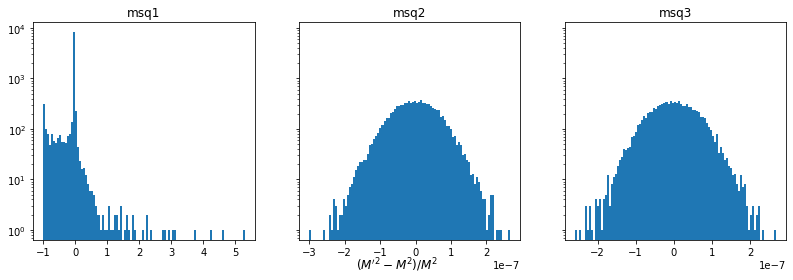

In [7]:
rng = np.random.default_rng(1)

p1 = 10 ** rng.uniform(0, 5, size=10000)
p2 = 10 ** rng.uniform(0, 5, size=10000)
m1 = 10 ** rng.uniform(-5, 5, size=10000)
m2 = 10 ** rng.uniform(-5, 5, size=10000)

# as reference we use naive formula computed with mpmath
M0 = []
with mp.workdps(100):
    for p1i, p2i, m1i, m2i in zip(p1, p2, m1, m2):        
        p1i = mp.mpf(p1i)
        p2i = mp.mpf(p2i)
        
        m1_sq = mp.mpf(m1i) ** 2
        m2_sq = mp.mpf(m2i) ** 2

        e1 = mp.sqrt(p1i ** 2 + m1_sq)
        e2 = mp.sqrt(p2i ** 2 + m2_sq)

        M0.append(m1_sq + m2_sq + 2 * (e1 * e2 - p1i * p2i))

M0 = np.array(M0, dtype=float)

M = {f.__name__: f(p1.astype(np.float32),
       p2.astype(np.float32),
       m1.astype(np.float32),
       m2.astype(np.float32)) for f in (msq1, msq2, msq3)}

fig, ax = plt.subplots(1, len(M), figsize=(len(M) * 4.5, 4), sharey=True)
for (fname, Mi), axi in zip(M.items(), ax):    
    axi.hist((Mi - M0) / M0, bins=100)
    axi.set_yscale("log")
    axi.set_title(fname)
fig.supxlabel(r"$(M'^2 - M^2) / M^2$");

### Solution in 3D

In 3D, the solution is a bit more complex than in the 1D case. We have now

$$
E_1 E_2 - \vec{p}_1 \vec{p}_2 = |\vec{p}_1| |\vec{p}_2| \left(\sqrt{x + 1} - \frac{\vec{p}_1 \vec{p}_2}{|\vec{p}_1| |\vec{p}_2|}\right) = |\vec{p}_1| |\vec{p}_2| \left(\sqrt{x + 1} - \cos{\alpha}\right)
$$

where $\alpha$ is the angle between $\vec{p}_1$ and $\vec{p}_2$. We have again a numerical instability for small $x$ and small $\alpha$, when $\vec{p}_1$ and $\vec{p}_2$ are nearly parallel, which happens often in practice.

To avoid the instability, we use a similar trick as before

$$
\sqrt{x + 1} - \cos{\alpha} = \frac{x + 1 - \cos^2{\alpha}}{\sqrt{x + 1} + \cos{\alpha}} = \frac{x + \sin^2{\alpha}}{\sqrt{x + 1} + \cos{\alpha}}
$$

We again avoided the subtraction of two numbers which are almost 1. We now face an additional issue. The naive computation of $\alpha$ is also not numerically stable for small $\alpha$ and we need [another trick from Stackoverflow](https://scicomp.stackexchange.com/questions/27689/numerically-stable-way-of-computing-angles-between-vectors) to compute it accurately,

$$
\alpha = \rm{arctan2}(|\vec{p}_1 \times \vec{p}_2|, \vec{p}_1 \vec{p}_2 )
$$

where $\rm{arctan2}$ refers to the computer function with the same name. 

In [80]:
# (slightly less) naive implementation
def msq1(px1, py1, pz1, px2, py2, pz2, m1, m2):
    p1_sq = px1 ** 2 + py1 ** 2 + pz1 ** 2
    p2_sq = px2 ** 2 + py2 ** 2 + pz2 ** 2
    m1_sq = m1 ** 2
    m2_sq = m2 ** 2
    
    # energies of particles 1 and 2
    e1 = np.sqrt(p1_sq + m1_sq)
    e2 = np.sqrt(p2_sq + m2_sq)

    # dangerous cancelation in third term
    return m1_sq + m2_sq + 2 * (e1 * e2 - (px1 * px2 + py1 * py2 + pz1 * pz2))

In [81]:
# numerically stable calculation of angle
@nb.njit
def angle(x1, y1, z1, x2, y2, z2):
    a = np.empty_like(x1, dtype=x1.dtype)
    for i in nb.prange(len(x1)):
        v1 = np.array((x1[i], y1[i], z1[i]), dtype=x1.dtype)
        v2 = np.array((x2[i], y2[i], z2[i]), dtype=x2.dtype)
        v3 = np.cross(v1, v2)
        a[i] = np.arctan2(np.dot(v3, v3) ** 0.5, np.dot(v1, v2))
    return a


@nb.njit
def msq2(px1, py1, pz1, px2, py2, pz2, m1, m2):
    p1_sq = px1 ** 2 + py1 ** 2 + pz1 ** 2
    p2_sq = px2 ** 2 + py2 ** 2 + pz2 ** 2
    a = angle(px1, py1, pz1, px2, py2, pz2)
    sin_theta_sq = np.sin(a) ** 2
    m1_sq = m1 ** 2
    m2_sq = m2 ** 2
    x1 = m1_sq / p1_sq
    x2 = m2_sq / p2_sq
    x = x1 + x2 + x1 * x2
    y = 2 * np.sqrt(p1_sq * p2_sq) * (x + sin_theta_sq) / (np.sqrt(x + 1) + np.cos(a))
    return m1_sq + m2_sq + y

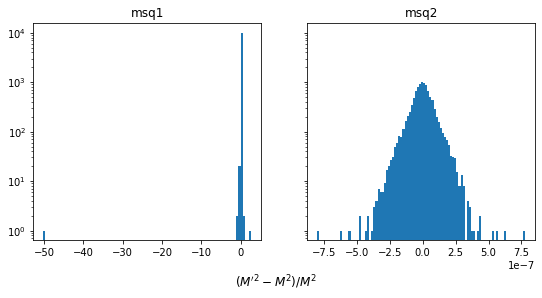

In [82]:
rng = np.random.default_rng(1)

dtype = np.float32
px1 = 10 ** rng.uniform(0, 3, size=10000).astype(dtype)
py1 = 10 ** rng.uniform(0, 3, size=10000).astype(dtype)
pz1 = 10 ** rng.uniform(0, 5, size=10000).astype(dtype)
px2 = 10 ** rng.uniform(0, 3, size=10000).astype(dtype)
py2 = 10 ** rng.uniform(0, 3, size=10000).astype(dtype)
pz2 = 10 ** rng.uniform(0, 5, size=10000).astype(dtype)
m1 = 10 ** rng.uniform(-5, 5, size=10000).astype(dtype)
m2 = 10 ** rng.uniform(-5, 5, size=10000).astype(dtype)

# as reference we use naive formula computed with mpmath
M0 = []
with mp.workdps(100):
    for px1i, py1i, pz1i, px2i, py2i, pz2i, m1i, m2i in zip(px1, py1, pz1, px2, py2, pz2, m1, m2):
        px1i = mp.mpf(float(px1i))
        py1i = mp.mpf(float(py1i))
        pz1i = mp.mpf(float(pz1i))
        px2i = mp.mpf(float(px2i))
        py2i = mp.mpf(float(py2i))
        pz2i = mp.mpf(float(pz2i))
        
        m1_sq = mp.mpf(float(m1i)) ** 2
        m2_sq = mp.mpf(float(m2i)) ** 2

        e1 = mp.sqrt(px1i ** 2 + py1i ** 2 + pz1i ** 2 + m1_sq)
        e2 = mp.sqrt(px2i ** 2 + py2i ** 2 + pz2i ** 2 + m2_sq)

        M0.append(m1_sq + m2_sq + 2 * (e1 * e2 - (px1i * px2i + py1i * py2i + pz1i * pz2i)))

M0 = np.array(M0, dtype=float)

M = {f.__name__: f(px1, py1, pz1, px2, py2, pz2, m1, m2) for f in (msq1, msq2)}

fig, ax = plt.subplots(1, len(M), figsize=(len(M) * 4.5, 4), sharey=True)
for (fname, Mi), axi in zip(M.items(), ax):
    d = (Mi - M0) / M0
    axi.hist(d, bins=100)
    axi.set_yscale("log")
    axi.set_title(f"{fname}")
fig.supxlabel(r"$(M'^2 - M^2) / M^2$", y=-0.05);